In [1]:

from LanguageModels.CustomWord2Vec import CustomWord2Vec
from LanguageModels.Word2Vec import Word2Vec

from Preprocessing.DataLoader import DataLoader
from Preprocessing.LemmatizerPreprocessor import LemmatizerPreprocessor

from sklearn.metrics import classification_report, confusion_matrix, silhouette_score, silhouette_samples,\
accuracy_score
import numpy as np

from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/evandowns/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/evandowns/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/evandowns/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/evandowns/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
data = DataLoader('../data/EMNLP2020.csv').load()

# Load preprocessor
lp = LemmatizerPreprocessor()

w2v = CustomWord2Vec(path='../data/customw2v_50.p')

# multiclass case
data, label = w2v.featurize(data, lp, mode='multiclass')
#data, label = w2v.featurize(data, lp, mode='multiclass', remove_neg_samples=True)
print(len(data))
print(len(label))
label = label.ravel()
label = label - 1

1450
1450


In [3]:
np.unique(label)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

# Visualize data

In [27]:
%matplotlib widget

In [28]:
fig = plt.figure(1, figsize=(7, 5))
ax = Axes3D(fig, elev=-150, azim=110)
data_reduced = PCA(n_components=3).fit_transform(data)

ax.scatter(data_reduced[:, 0], data_reduced[:, 1], data_reduced[:, 2], c=label,
           cmap=plt.cm.Set1, edgecolor='k', s=40)
ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])

# rotate the axes and update
# for angle in range(0, 360):
#     ax.view_init(30, 40)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

[Text(-0.2, 0, ''),
 Text(-0.15000000000000002, 0, ''),
 Text(-0.1, 0, ''),
 Text(-0.04999999999999999, 0, ''),
 Text(0.0, 0, ''),
 Text(0.04999999999999999, 0, ''),
 Text(0.10000000000000003, 0, ''),
 Text(0.15000000000000002, 0, ''),
 Text(0.2, 0, ''),
 Text(0.25, 0, '')]

In [10]:
label_adj = label.copy()
label_adj[label < 10] = 0
fig = plt.figure(figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
ax.scatter(data_reduced[:, 0], data_reduced[:, 1], data_reduced[:, 2], c=label_adj,
           cmap=plt.cm.Set1, edgecolor='k', s=40)
ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

[Text(-0.2, 0, ''),
 Text(-0.15000000000000002, 0, ''),
 Text(-0.1, 0, ''),
 Text(-0.04999999999999999, 0, ''),
 Text(0.0, 0, ''),
 Text(0.04999999999999999, 0, ''),
 Text(0.10000000000000003, 0, ''),
 Text(0.15000000000000002, 0, ''),
 Text(0.2, 0, ''),
 Text(0.25, 0, '')]

In [13]:
%matplotlib inline

# Assign Kmeans cluster to a topic

In [14]:
def getSummary(abstracts):
    
    sim_arr = []
    
    #for each abstract calculate the cosine similarity to every other abstract
    for ab in abstracts:
        cos_num = np.dot(abstracts, ab)
        cos_denom = np.linalg.norm(ab) * np.sqrt(np.sum(np.square(abstracts), axis= 1))
        sim_arr.append(np.divide(cos_num, cos_denom))
    
    #for each abstract calculate the average similarity
    sim_avg_arr = np.mean(np.array(sim_arr), axis = 1)
    #get the indices of the top 5 abstracts that are most similar to the rest of the abstracts
    top_5_abstract_inds = sim_avg_arr.argsort()[::-1][:5]
    #take the average of these top 5 abstracts
    class_summary = np.mean(abstracts[top_5_abstract_inds], axis = 0)
    
    return class_summary
    


#for each class generate a summary vector
topic_summaries = []
for i in range(0,11):
    inds = label == i
    abstracts_i_class = data[inds, :]
    i_class_summary = getSummary(abstracts_i_class)
    topic_summaries.append(i_class_summary)
    
topic_summaries = np.array(topic_summaries)

    

In [15]:
#fit Kmeans with 11 clusters to the dataset
kmeans = KMeans(n_clusters=11, random_state=0, init=topic_summaries).fit(data)
centers = kmeans.cluster_centers_

#for each cluster center assign the cluster to the closest topic summary vector using cosine similarity
assigned_label = []
for center in centers:
    cos_num = (topic_summaries @ center.reshape(-1,1)).reshape(1, 11)
    cos_denom = np.linalg.norm(center) * np.sqrt(np.sum(np.square(topic_summaries), axis= 1)).reshape(1,-1)
    sim_vec = np.divide(cos_num, cos_denom)
    assigned_label.append(np.argmax(sim_vec))
    
print(assigned_label)   


[8, 9, 10, 4, 2, 1, 10, 10, 10, 9, 10]


/Users/evandowns/miniconda3/envs/CS7641proj/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:984: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


In [16]:
# calculate accuracy multi class and binary
kmeans_class = kmeans.predict(data)
assigned_class = kmeans_class.copy()

for i in range(len(assigned_label)):
    inds = kmeans_class == i
    assigned_class[inds] = assigned_label[i]
    

print('multi-class')
print(accuracy_score(label, assigned_class))

assigned_class_bin = assigned_class.copy()

assigned_class_bin[assigned_class_bin < 10] = 0
assigned_class_bin[assigned_class_bin == 10] = 1
label_bin = label.copy()
label_bin[label_bin < 10] = 0
label_bin[label_bin == 10] = 1

print('binary class')
print(accuracy_score(label_bin, assigned_class_bin))

multi-class
0.4889655172413793
binary class
0.8703448275862069


In [17]:
confusion_matrix(label, assigned_class)

array([[  0,   6,  14,   0,  12,   0,   0,   0,  12,  24,  13],
       [  0,  33,  26,   0,  25,   0,   0,   0,  14,  53,  14],
       [  0,   3,  11,   0,   5,   0,   0,   0,   1,   5,  11],
       [  0,  18,  40,   0,  27,   0,   0,   0,  12,  33,   9],
       [  0,  12,  13,   0,  15,   0,   0,   0,   5,  16,   4],
       [  0,   7,   6,   0,   9,   0,   0,   0,  12,  12,  10],
       [  0,   2,   3,   0,   4,   0,   0,   0,   1,   6,  12],
       [  0,  17,  16,   0,   6,   0,   0,   0,  10,  13,   9],
       [  0,   0,   0,   0,   1,   0,   0,   0,   3,   3,   4],
       [  0,   6,  16,   0,  12,   0,   0,   0,  15,  41,   8],
       [  0,   1,  10,   0,  30,   0,   0,   0,  46,   7, 606]])

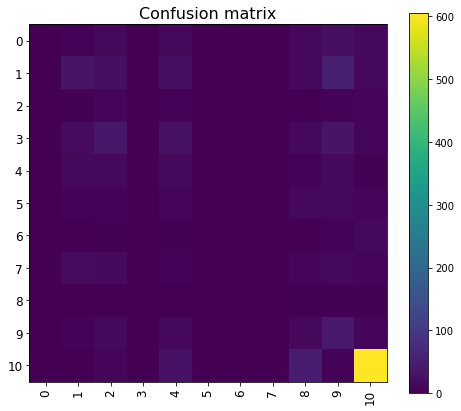

In [18]:
confusion_matrix(label, assigned_class)
plt.figure(figsize=(8, 7))
plt.imshow(confusion_matrix(label, assigned_class))
plt.title('Confusion matrix', fontsize=16)
plt.xticks(np.arange(11), np.unique(label), rotation=90, fontsize=12)
plt.yticks(np.arange(11), np.unique(label), fontsize=12)
plt.colorbar()
plt.show()

# Clustering Evaulation

### Elbow Method

In [21]:
#function for the elbow method
def find_optimal_num_clusters(data, model, max_K=19): # [10 pts]
    

    #raise NotImplementedError
    
    lossArr = np.zeros((max_K, 2))
    
    lossArr[:, 0] = range(1,max_K+1)
    
    for i in range(0,max_K):
        
        if model == 'K-means':
            kmeans = KMeans(n_clusters=i+1, random_state=0).fit(data)
            lossArr[i, 1] = kmeans.inertia_
        
    plt.figure(figsize=(8, 6))
    plt.plot(lossArr[:, 0], lossArr[:,1])
    plt.title(model+' Loss vs. Number of Clusters')
    plt.xlabel('k value')
    plt.ylabel('sum of squared distances')
    
    return lossArr[:, 1].tolist()

[44.89269572910385,
 24.45768860065856,
 19.72390987168612,
 17.22331232059208,
 15.046956409758986,
 13.823177617471845,
 12.925773256879827,
 12.249897715365965,
 11.659395454696385,
 11.208330405350278,
 10.882325863657357]

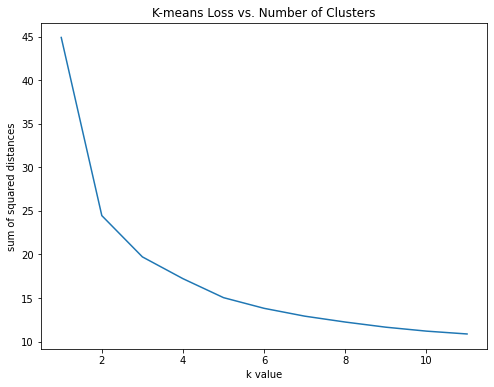

In [22]:
find_optimal_num_clusters(data,'K-means', max_K=11)

### sillhouette score

In [28]:
def sillhouette_Viz(data, model, range_n_clusters):



    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        #fig, (ax1, ax2) = plt.subplots(1, 2)
        fig, ax1 = plt.subplots()
        fig.set_size_inches(9, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(data) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        if model == "K-means":
            clusterer = KMeans(n_clusters=n_clusters, random_state=10)
            cluster_labels = clusterer.fit_predict(data)
        elif model == "GMM":
            clusterer = GaussianMixture(n_components=n_clusters, random_state=0)
            cluster_labels = clusterer.fit_predict(data)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(data, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(data, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        plt.suptitle(("Silhouette analysis for " + model+  " clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')

    plt.show()

### K-means

For n_clusters = 2 The average silhouette_score is : 0.3755664948597422
For n_clusters = 3 The average silhouette_score is : 0.25783066786329867
For n_clusters = 4 The average silhouette_score is : 0.22601475700755944
For n_clusters = 5 The average silhouette_score is : 0.22428453656283207
For n_clusters = 6 The average silhouette_score is : 0.20983239789655286
For n_clusters = 7 The average silhouette_score is : 0.19602781194950716
For n_clusters = 8 The average silhouette_score is : 0.18492380732321012
For n_clusters = 9 The average silhouette_score is : 0.17873808906804087
For n_clusters = 10 The average silhouette_score is : 0.16286658652436756
For n_clusters = 11 The average silhouette_score is : 0.15883628909975575


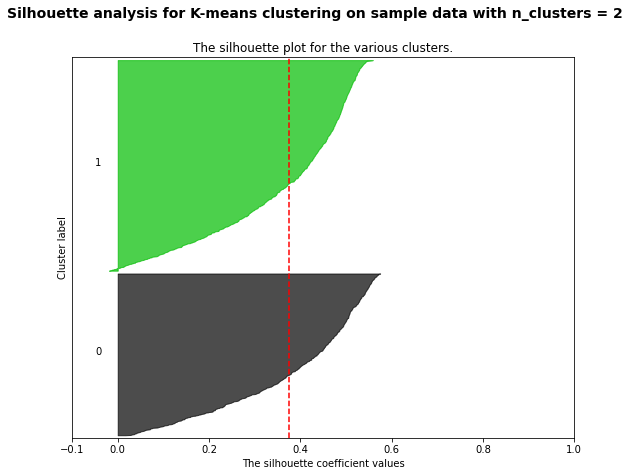

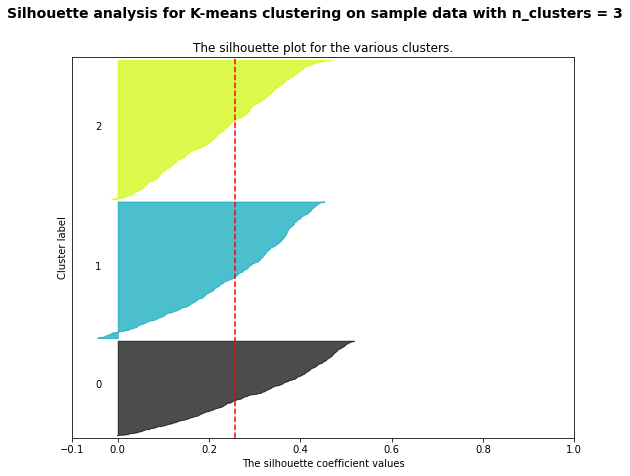

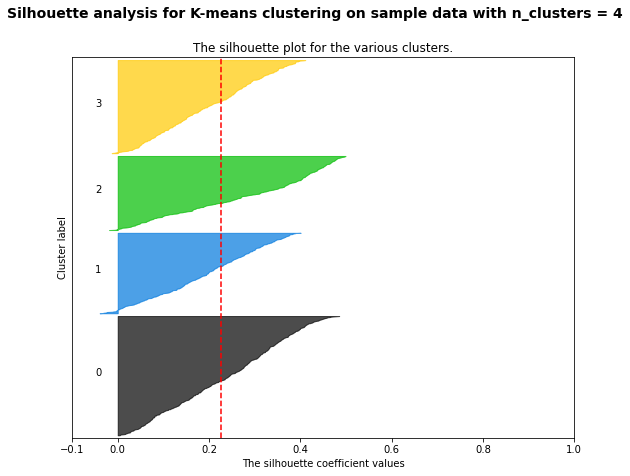

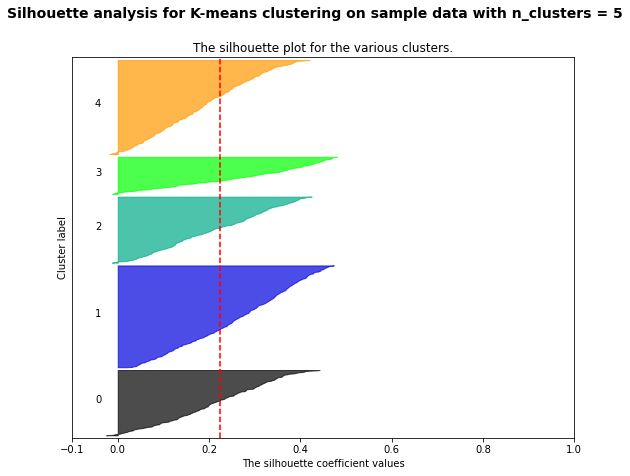

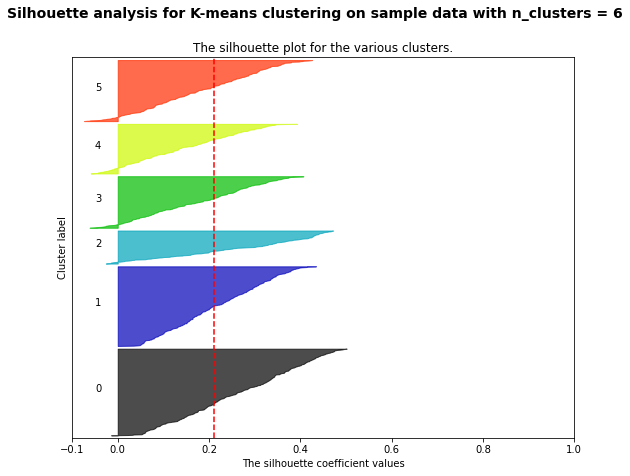

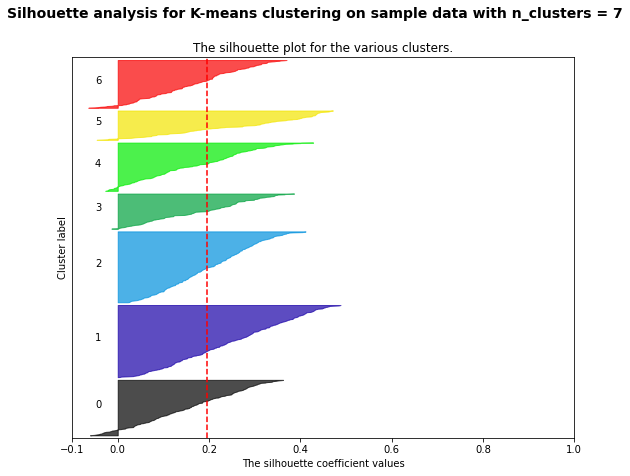

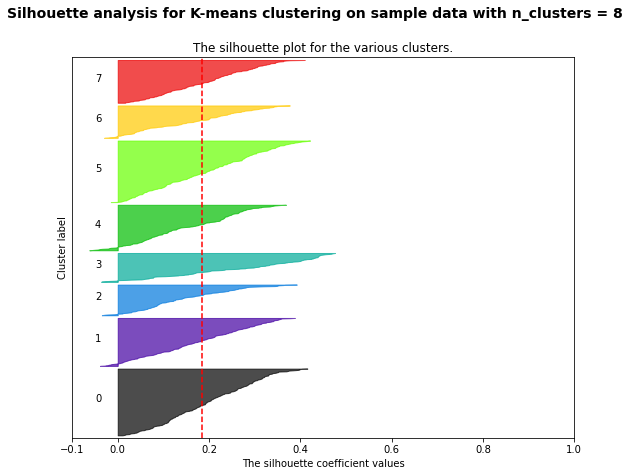

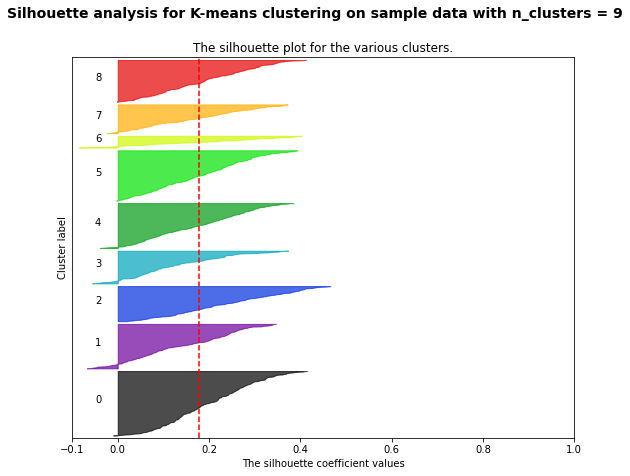

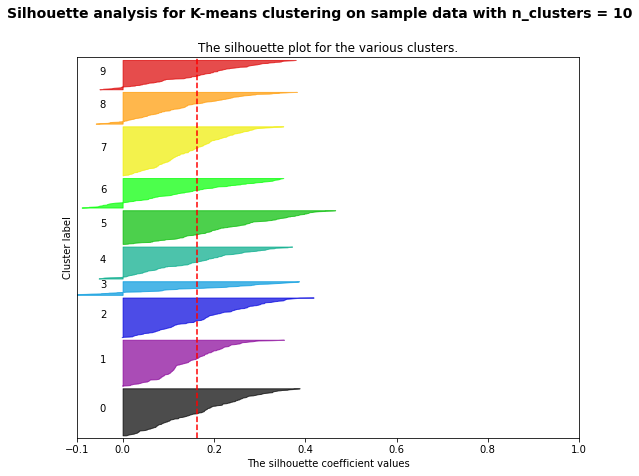

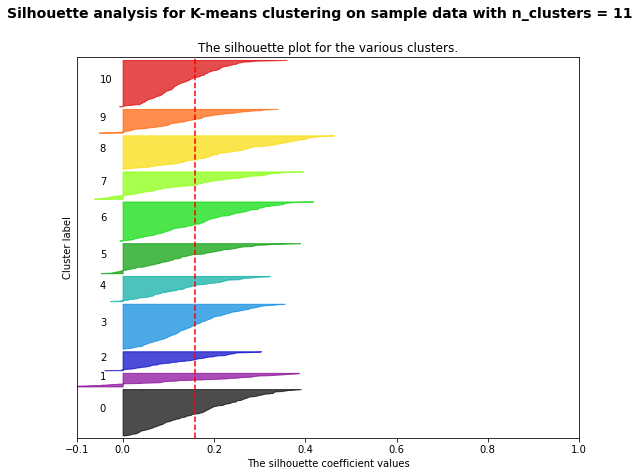

In [29]:
sillhouette_Viz(data, 'K-means', [2,3,4,5,6,7,8,9,10,11])

### Gaussian Mixture Model

For n_clusters = 2 The average silhouette_score is : 0.25280570403836433
For n_clusters = 3 The average silhouette_score is : 0.09595163594889489
For n_clusters = 4 The average silhouette_score is : 0.010938121726883653
For n_clusters = 5 The average silhouette_score is : 0.03526910634678407
For n_clusters = 6 The average silhouette_score is : 0.01219757046406233
For n_clusters = 7 The average silhouette_score is : 0.023254671799387797
For n_clusters = 8 The average silhouette_score is : 0.030552726231985187
For n_clusters = 9 The average silhouette_score is : 0.04252528851360627
For n_clusters = 10 The average silhouette_score is : 0.03671802654071032
For n_clusters = 11 The average silhouette_score is : 0.04378688927661297


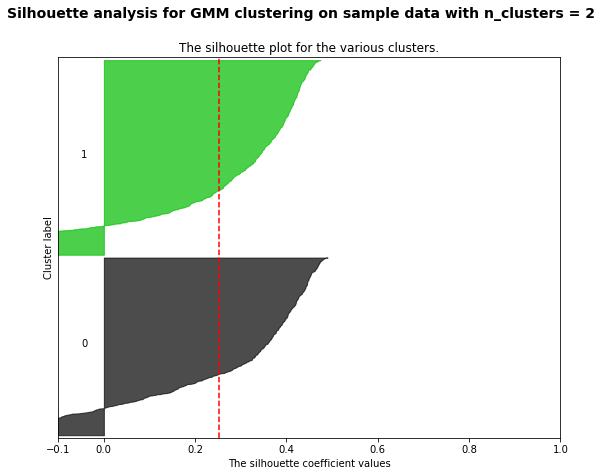

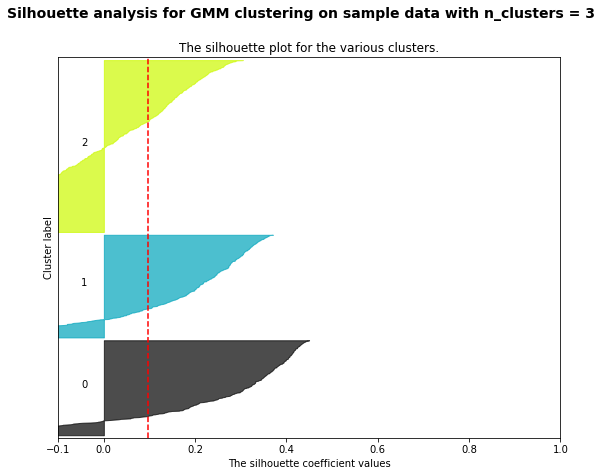

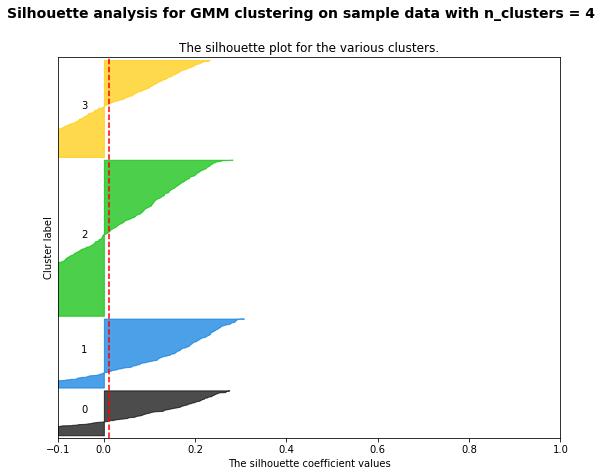

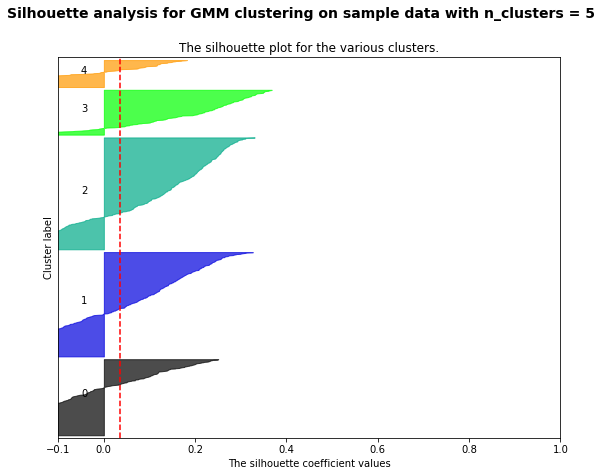

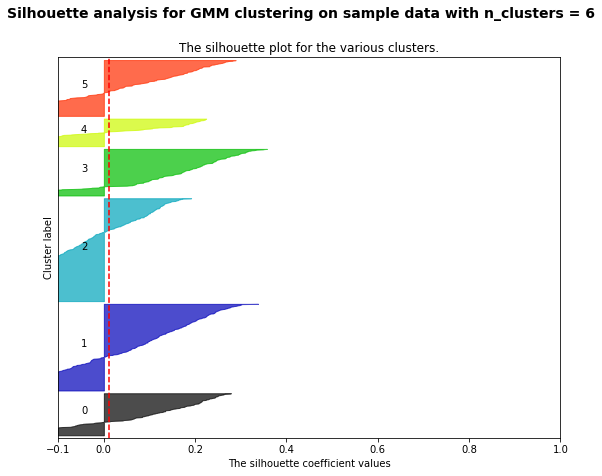

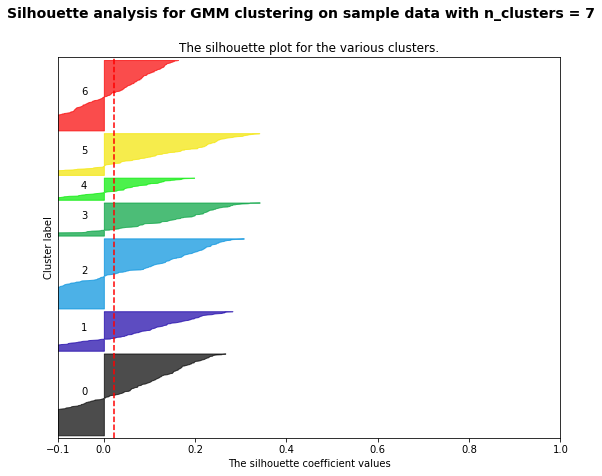

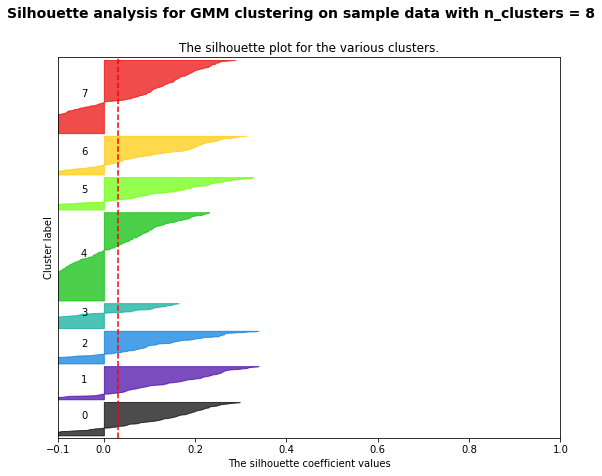

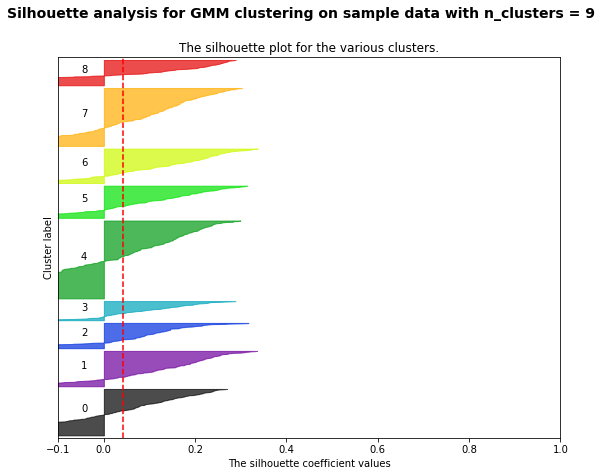

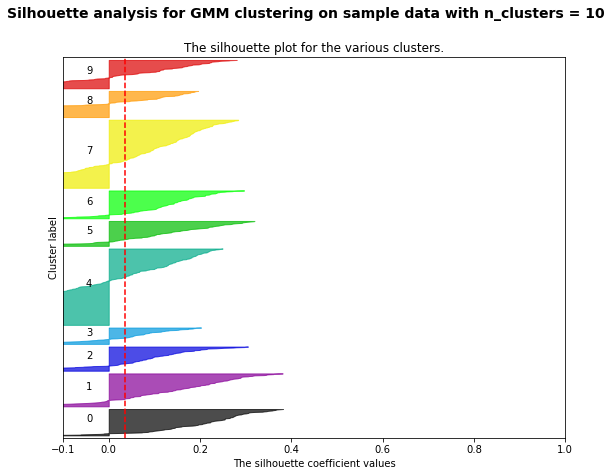

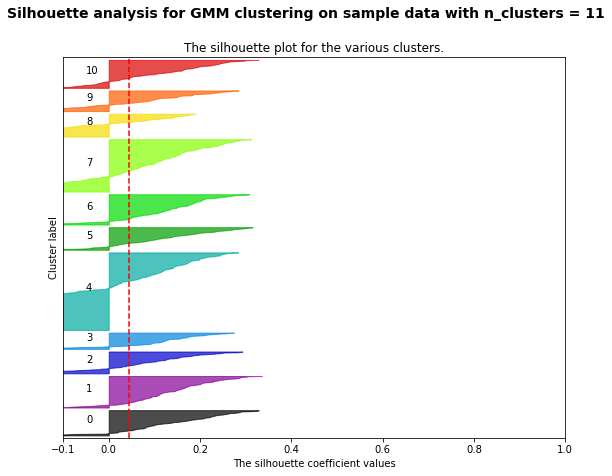

In [30]:
sillhouette_Viz(data, 'GMM', [2,3,4,5,6,7,8,9,10,11])